# Notebook computazionale per il problema NLIN
###              Step - 4: analisi numerica dell'approssimazione con gaussiana

Risultati della volta scorsa: possiamo eseguire il primo integrale dei due espressi in


$$\large
X_{0, m, m} = f_B(z_m) \dfrac{U_0^4}{1+D^2(z_m)}  \dfrac{1}{\sqrt{2}}\int_{0}^{L}dz \int_{\mathbb{R}}d\eta
	 \exp\left[-\dfrac{\eta^2}{T_0^2(1+D^2(z))} \right] \exp\left[-\dfrac{s^2}{2T_0^2(1+D^2(z))} \right]
$$

infatti, integrando in $\eta$, abbiamo


$$\large
X_{0, m, m} = \dfrac{\sqrt{\pi} U_0^4 T_0}{\sqrt{2}} \int_{0}^{L}dz f_B(z) \dfrac{1}{(1+D^2(z))^{\frac{1}{2}}}   \exp\left[-\dfrac{(mT + \beta_2 \Omega z)^2}{2T_0^2(1+D^2(z))} \right]
$$

In [8]:
from sympy import * 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from IPython.display import display
import multiprocessing
from os.path import exists
import scipy.integrate as integrate
from scipy.special import erf
from integration import integrate_difference
import time

t, z, beta2, Omega, m, T, T0, D = symbols('t z beta2 Omega m T T0 D')
Dm = -m*T/Omega/T0**2

NameError: name 'symbols' is not defined

In [9]:
t, z, beta2, Omega, m, T, T0, D = symbols('t z beta2 Omega m T T0 D')
Dm = -m*T/Omega/T0**2

NameError: name 'symbols' is not defined

Le integrande da confrontare sono:
$$\large h = \dfrac{1}{\left(1+D^2(z)\right)^{\frac{1}{2}}} \exp\left[-\dfrac{(mT + \beta_2 \Omega z)^2}{2T_0^2(1+D^2(z))} \right]$$
$$\large h_{approx} = \dfrac{1}{\left(1+D^2(z_m)\right)^{\frac{1}{2}}} \exp\left[-\dfrac{(mT + \beta_2 \Omega z)^2}{2T_0^2(1+D^2(z_m))} \right]$$
--------
Dove
$$\large D(z) = \dfrac{z \beta_2}{T_0^2}$$

$$\large D(z_m) = \dfrac{-mT \beta_2 }{\beta_2 \Omega T_0^2} = \dfrac{-mT}{\Omega T_0^2}  $$

## Definizione delle integrande

In [10]:
h_plus =  (1/sqrt(1+(z*beta2/T0**2)**2)) * exp(-(m*T+beta2* Omega* z)**2/(2*T0**2*(1+(z**2*beta2**2)/(T0**4)))) 
first = diff(h_plus, z).subs(z, -m*T/(beta2*Omega))
second = diff(diff(h_plus, z), z).subs(z, -m*T/(beta2*Omega))
second.subs(T, T0)
#display(h_plus)
h_simp = (1/sqrt(1+(-m*T/(Omega * T0**2))**2)) * exp(-(m*T+beta2* Omega* z)**2/(2*T0**2*(1+(-m*T/(Omega * T0**2))**2))) 
#display(h_simp)

NameError: name 'sqrt' is not defined

### Esempio: parametri ipotizzati nella scorsa riunione

In [11]:
params = {Omega:2000e9,    # 100GHz channel spacing
          beta2:20e-27,  # standard dispersion (low side)
          T0:50e-12,    # 100ps half width 1/e power
          T:1e-10}       # 100ps: 10GHz modulation 
instance = h_plus.subs(params)
instance_approx = h_simp.subs(params)

zm = -1 * params[T]/(params[beta2] * params[Omega])
print("Inter-collision spacing: ", zm/1e3, "km")
h = lambdify((z, m), instance, "numpy")
h_approx = lambdify((z, m), instance_approx, "numpy")
print(-params[T0]**2/params[beta2] / 1e3 , " km")

NameError: name 'Omega' is not defined

Grafico delle forme d'onda visualizzato a finestre di `window_steps` collisioni, con `N_collisions` collisioni per finestra, spaziate di `decimation` collisioni. 

NameError: name 'params' is not defined

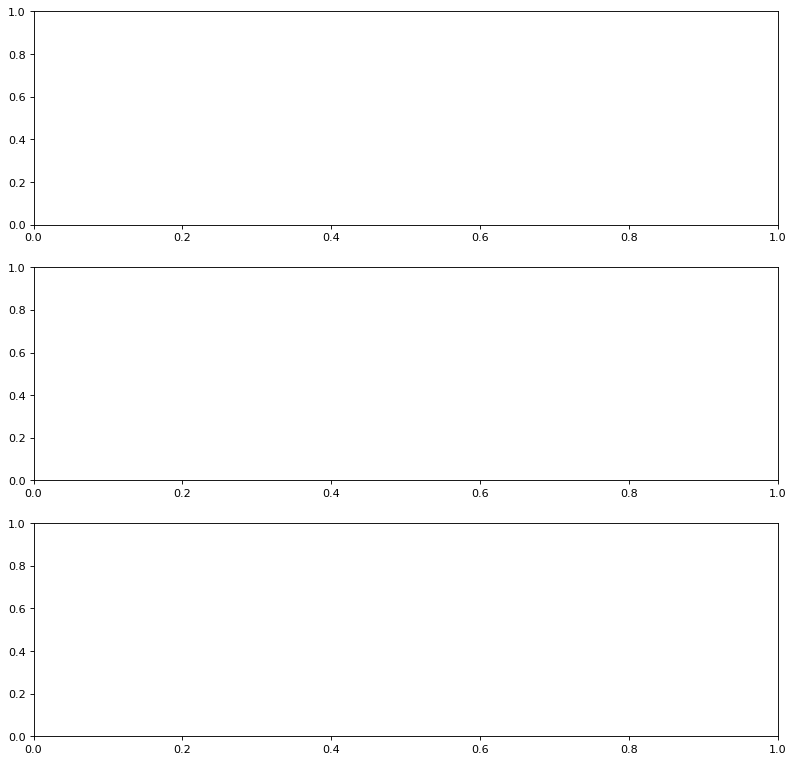

In [12]:
counter = 0
window_steps = 10
N_collisions = 5
decimation = 1

guard = 75000
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), dpi=80)
for p in ax:
    start_collision = counter * window_steps

    first_zm = - start_collision * params[T] / (params[beta2] * params[Omega]) 
    last_zm = - (N_collisions * decimation + start_collision) * params[T] / (params[beta2] * params[Omega])
    space = (np.array(range(0, 10000)) * (last_zm - first_zm + 2*guard)/10000) + (first_zm - guard) # sum guards before and afters

    print("From ", space[0]/1000, "km", "to ", space[-1]/1000, "km :")
    print("\tCollisions number :", *[k*decimation + start_collision for k in range(N_collisions)], "\n")
    
    for k in [k*decimation + start_collision for k in range(N_collisions)]:
        p.plot(space/1e3, h(space, k), color="green")
        p.plot(space/1e3, h_approx(space, k), color="red")
        p.set_xlabel("z [km]")
        p.set_ylabel("Amplitude")
        #p.set_title("From " + str(first_zm/zm) + "zm to " + str(last_zm/zm) + "zm :")
        p.grid()
    counter+=1

From  -75.0 km to  199.9725 km :
	Collisions number : 0 1 2 3 4 

From  175.0 km to  449.97249999999997 km :
	Collisions number : 10 11 12 13 14 

From  425.0 km to  699.9725 km :
	Collisions number : 20 21 22 23 24 



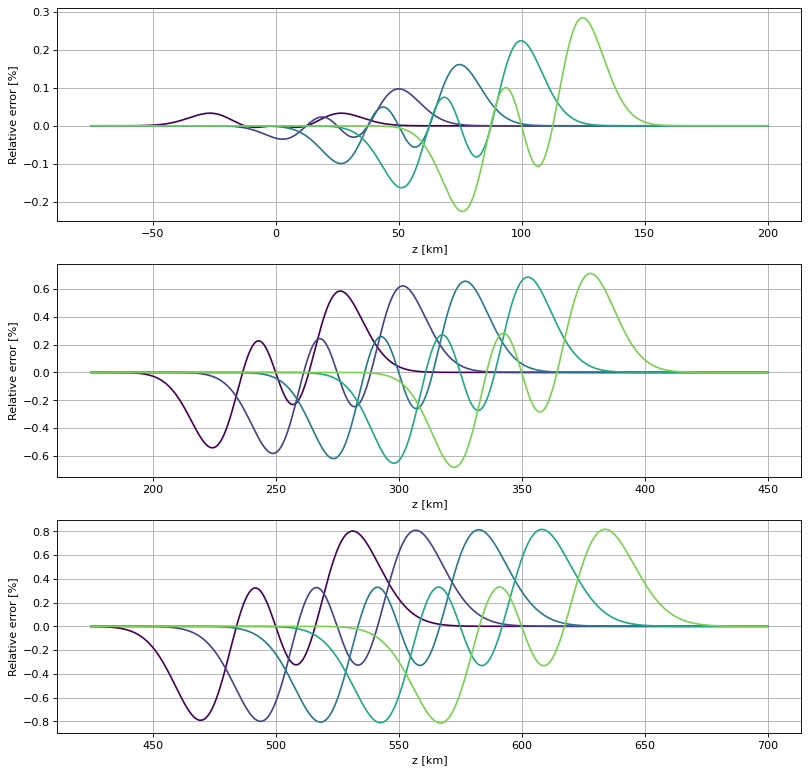

In [5]:
colors = pl.cm.viridis(np.linspace(0,0.8,N_collisions))
counter = 0

fig0, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), dpi=80)
for p in ax:
    start_collision = counter * window_steps

    first_zm = - start_collision * params[T] / (params[beta2] * params[Omega]) 
    last_zm = - (N_collisions * decimation + start_collision) * params[T] / (params[beta2] * params[Omega])
    space = (np.array(range(0, 10000)) * (last_zm - first_zm + 2*guard)/10000) + (first_zm - guard) # sum guards before and afters
    print("From ", space[0]/1000, "km", "to ", space[-1]/1000, "km :")
    print("\tCollisions number :", *[k*decimation + start_collision for k in range(N_collisions)], "\n")
    
    for k in [k*decimation + start_collision for k in range(N_collisions)]:
        p.plot(space/1e3, (h(space, k)-h_approx(space, k))*100, color=colors[int((k - start_collision)/decimation)])
        p.set_xlabel("z [km]")
        p.set_ylabel("Relative error [%]")
        #p.set_title("From " + str(first_zm/zm) + "zm to " + str(last_zm/zm) + "zm :")
        p.grid()
    counter+=1


## Funzione di integrazione numerica

In [6]:
def score(prms, fun0, fun1,  collision_interval):
    
    # synchronization of parallel processes
    time.sleep(1)
    
    zm = -prms[T]/(prms[Omega]*prms[beta2])
    N_collisions = len(collision_interval)
    L = zm * N_collisions
    
    print("Running... L = ", L/1e3, " km")
    #print("RUN params: \n\t", prms, "\n\tLink length = ", L/1000, " km")
    
    #display(fun0)
    #display(fun1)
    
    original = fun0.subs(prms)
    approximant = fun1.subs(prms)
    absolute_e = np.ones(N_collisions)
    relative_e = np.zeros(N_collisions)
    original_integral = np.ones(N_collisions)
    approximant_integral = np.ones(N_collisions)
    
    method = "scipy"
    if method == "sympy":
        l = 0
        for k in collision_interval:
            absolute_e[l] = Integral(original.subs(m, k) - approximant.subs(m, k), (z, 0, L)).evalf(1) 
            l += 1
        l = 0
        for k in collision_interval:
            relative_e[l] = absolute_e[k]/ Integral(original.subs(m, k), (z, 0, L)).evalf(1)
            l += 1
    else:
        lam0 = lambdify([z, m], original)
        lam1 = lambdify([z, m], approximant)
        l = 0
        xx = np.linspace(0, L, 10000) # Number of uniform distributed evaluation points
        for k in collision_interval:            
            #absolute_e[l] = integrate.quad(lambda zz: lam1(zz, k) - lam0(zz, k), 0, L)[0]
            approximant_integral[l] = integrate.trapezoid(lam1(xx, k), xx)
            original_integral[l] = integrate.trapezoid(lam0(xx, k), xx)
            
            if (original_integral[l]> np.finfo(np.double).eps or True):
                
                # genuine integration - affected by roundoff errors
                relative_e[l] = (approximant_integral[l] - original_integral[l])/(original_integral[l])
                
                # fake relative wrt gaussian integral
                # relative_e[l] = (approximant_integral[l] - original_integral[l])/(np.sqrt(2) * prms[T0])
            else:
                relative_e[l] = float("nan")
            l += 1

    absolute_e = approximant_integral - original_integral
    #print(absolute_e)
    #print(relative_e)

    return [absolute_e, relative_e, original_integral]

### Impostiamo i parametri per la simulazione

In [7]:
setups = [{Omega:1e11,    
          beta2:-2.2958067590909893e-26,
          T0: (w+1) * 100e-12,    
          T:1e-10} for w in range(1)]

refresh = True
if(not exists("./error_integral.npy") or refresh):
    
    # define collisions of interest (constant-spaced collisions)
    initial_collision = 0
    N = 20
    decimation = 1
    interval = np.array(range(initial_collision, initial_collision + N * decimation, decimation))
    
    abs_err = np.zeros((len(setups), N))
    rel_err = np.zeros((len(setups), N))
    
    # for i in range(len(setups)):
        # relative_error[i, :] = score(setups[i], h_plus, h_simp, N)
        
        
    # process-based parallelism to speed up integration calculations
    #score(setups[1], h_plus, h_simp, interval)
    pool = multiprocessing.Pool()
    lil = np.array(pool.starmap(score, [(s, h_plus, h_simp, interval) for s in setups]))
    pool.close()

    abs_err = np.array(lil[:, 0::3, :])
    rel_err = np.array(lil[:, 1::3, :])
    orig = np.array(lil[:, 2::3, :])

    abs_err = np.array(abs_err[:, 0, :])
    rel_err = np.array(rel_err[:, 0, :])
    orig = np.array(orig[:, 0, :])
    #print("--------")
    #print(abs_err)
    #print(rel_err)
    #print(orig)

    #print(shape(abs_err))
    #print(shape(rel_err))
    
    np.save("abs_err_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation), abs_err)
    np.save("original_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation), orig)

Running... L =  5000.0  km


L'integrale (gaussiano) della funzione approssimante è calcolabile *analiticamente*, ed è costante, pari a:

$$\Large \dfrac{T_0 \sqrt{2\pi}}{\beta_2 \Omega}$$
Possiamo quindi confrontare gli effetti di questa approssimazione, non solo rispetto alla funzione non approssimata, ma anche rispetto al comportamento ai bordi della fibra.

Integrals vs collision number for linearly spaced T_0 (100.0  -> 100.0) ps


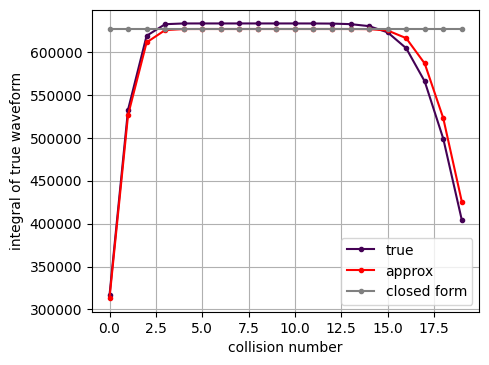

Errors vs collision number for linearly spaced T_0 (100.0  -> 100.0) ps


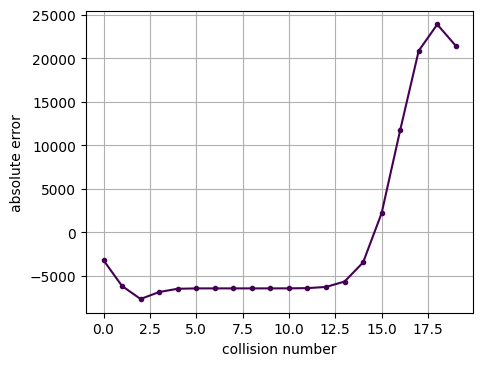

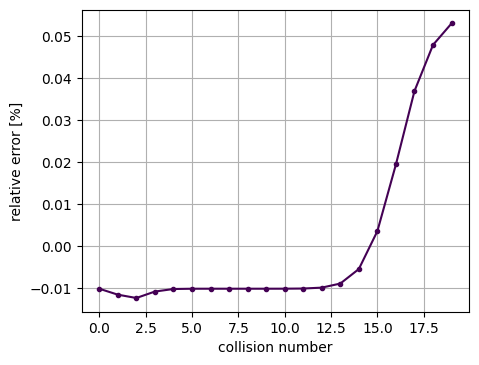

In [8]:
colors = pl.cm.viridis(np.linspace(0,0.8,len(setups)))
colors2 = pl.cm.autumn(np.linspace(0,0.8,len(setups)))

# Load results from file
#absolute_error = np.load("./abs_err_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation) + ".npy")
#original = np.load("./original_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation) + ".npy")

# Use previously defined variables
absolute_error = abs_err
relative_error = rel_err
original = orig
cut_initial_border = 0 # collisions

print("Integrals vs collision number for linearly spaced T_0 (" + str(setups[0][T0] * 1e12) + "  -> "+ str(setups[len(setups)-1][T0] * 1e12) +") ps")

fig7 = plt.figure(figsize=(5, 4), dpi=100)
for j in range(len(setups)):
    plt.plot(np.array(range(cut_initial_border, N))*decimation,
             original[j, cut_initial_border:],
             color=colors[j], marker=".", label="true")
    plt.plot(np.array(range(cut_initial_border, N))*decimation,
             original[j, cut_initial_border:] + absolute_error[j, cut_initial_border:],
             color=colors2[j], marker=".", label ="approx")
    plt.plot(np.array(range(cut_initial_border, N))*decimation,
            -np.ones(len(range(cut_initial_border, N))) / (setups[j][beta2] * setups[j][Omega]) * (setups[j][T0]) * np.sqrt(2*np.pi),
            color="grey", marker=".", label ="closed form")
plt.legend()
plt.grid()
plt.xlabel("collision number")
plt.ylabel("integral of true waveform")
plt.savefig("./plots/rel_error_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation) + ".png")
plt.show()

print("Errors vs collision number for linearly spaced T_0 (" + str(setups[0][T0] * 1e12) + "  -> "+ str(setups[len(setups)-1][T0] * 1e12) +") ps")

fig20 = plt.figure(figsize=(5, 4), dpi=100)
for j in range(len(setups)):
    plt.plot(np.array(range(cut_initial_border, N))*decimation,
             absolute_error[j, cut_initial_border:],
             color=colors[j], marker=".")
plt.grid()
plt.xlabel("collision number")
plt.ylabel("absolute error")
plt.savefig("./plots/abs_error_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation) + ".png")

fig21 = plt.figure(figsize=(5, 4), dpi=100)
for j in range(len(setups)):
    plt.plot(np.array(range(cut_initial_border, N))*decimation,
             abs_err[j, cut_initial_border:]/orig[j, cut_initial_border:],
             color=colors[j], marker=".")
plt.grid()
plt.xlabel("collision number")
plt.ylabel("relative error [%]")
plt.savefig("./plots/rel_error_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation) + ".png")

### Routine di integrazione numerica alternativa

In [9]:
setups = [{Omega:1e11,    
          beta2:-4e-27,
          T0: (w+1) * 100e-12,    
          T:1e-10} for w in range(1)]

initial_collision = 0
N = 20
decimation = 1
interval = np.array(range(initial_collision, initial_collision + N * decimation, decimation))

zm = -setups[0][T]/(setups[0][Omega] * setups[0][beta2])
L = N * decimation * zm * 1.0
abs_err = np.zeros((len(setups), N))

# Call binded library obtained from a Rust implementation (special thanks to G. De Lazzari)
ctr = 0
for s in setups:
    for m in interval:
        # def integrate_difference(u0, omega, beta2, t0, t, m, a, b, delta)
        abs_err[ctr, m] = integrate_difference(1.0, *s.values(), m, 0.0, L, 0.1)
        #print(f"{m}, {d}")
np.save("rust_abs_err_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation), abs_err)

Errors vs collision number for linearly spaced T_0 (100.0  -> 100.0) ps


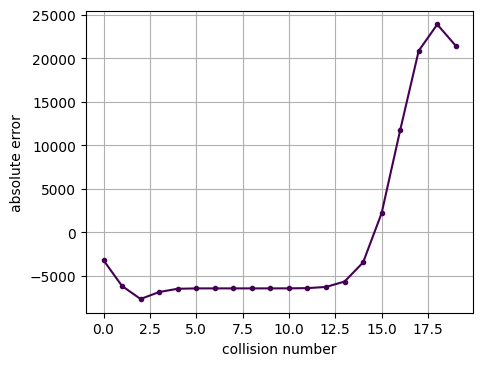

In [10]:
colors = pl.cm.viridis(np.linspace(0,0.8,len(setups)))
absolute_error = np.load("./rust_abs_err_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation) + ".npy")

cut_initial_border = 0 # collisions
print("Errors vs collision number for linearly spaced T_0 (" + str(setups[0][T0] * 1e12) + "  -> "+ str(setups[len(setups)-1][T0] * 1e12) +") ps")

fig20 = plt.figure(figsize=(5, 4), dpi=100)
for j in range(len(setups)):
    plt.plot(np.array(range(cut_initial_border, N))*decimation, 
             -absolute_error[j, cut_initial_border:],
             color=colors[j], marker=".")
plt.grid()
plt.xlabel("collision number")
plt.ylabel("absolute error")
plt.savefig("./plots/rust_abs_error_" + str(initial_collision) + "_to_" + str(initial_collision+N*decimation) + ".png")

## Approccio alternativo: espansione di Taylor (bivariata) delle integrande
L'approssimazione verte nel sostituire $D(z)$ con $D(z_m)$. 
Questa operazione può essere interpretata come un espansione all'ordine 0 della funzione attorno a $D(z) = D(z_m)$.

Possiamo quindi valutare l'errore dovuto alla variazione di $D$ lungo l'intervallo in cui la campana gaussiana è non trascurabile, tramite l'osservazione del termine di primo ordine, ad una distanza $z$ scelta in modo che la variazione di $D$ sia sufficientemente rappresentativa di quanto accade nella parte d'interesse.


$$\large h(z, D) = h(z, \bar{D}) + \left[\dfrac{\partial h}{\partial D}(z, \bar{D})\right] (D - \bar{D}) + \left[\dfrac{\partial^2 h}{\partial D^2}(z, \bar{D})\right] (D-\bar{D})^2 + o((D-\bar{D})^2) $$


Quindi limitiamo l'analisi al termine del primo ordine, e scegliamo una variazione di $D$ come quella che abbiamo a $z = z_m - \sigma$ dove $\sigma^2$ è il denominatore della curva gaussiana approssimante. 

In [11]:
t, z, beta2, Omega, m, T, T0, D = symbols('t z beta2 Omega m T T0 D')


f = (1/sqrt(1+D**2)) * exp(-(m*T+beta2* Omega* z)**2/(2*T0**2*(1+D**2)))
Dbar = -m*T/(Omega*T0**2)

# zero order term
h0 = f.subs(D, Dbar)

#first order coefficient
h1 = diff(f, D).subs({D: Dbar})
sigma = sqrt(2*T0**2*(1+Dbar**2))/(beta2 * Omega)
Dsigma = sigma * beta2 / T0**2

first_error = h1 * (D-Dbar)

print("Symbolic form for first order term:")
display(first_error)
print("symbolic form for first order term at D = D(sigma):")
display(first_error.subs(D, Dsigma).subs(params))

Symbolic form for first order term:


(D + T*m/(Omega*T0**2))*(T*m*exp(-(Omega*beta2*z + T*m)**2/(2*T0**2*(1 + T**2*m**2/(Omega**2*T0**4))))/(Omega*T0**2*(1 + T**2*m**2/(Omega**2*T0**4))**(3/2)) - T*m*(Omega*beta2*z + T*m)**2*exp(-(Omega*beta2*z + T*m)**2/(2*T0**2*(1 + T**2*m**2/(Omega**2*T0**4))))/(Omega*T0**4*(1 + T**2*m**2/(Omega**2*T0**4))**(5/2)))

symbolic form for first order term at D = D(sigma):


(0.04*m + 0.02*sqrt(2)*sqrt(0.0016*m**2 + 1))*(-0.16*m*(m - 4.0e-5*z)**2*exp(-2.0*(m - 4.0e-5*z)**2/(0.0016*m**2 + 1))/(0.0016*m**2 + 1)**(5/2) + 0.04*m*exp(-2.0*(m - 4.0e-5*z)**2/(0.0016*m**2 + 1))/(0.0016*m**2 + 1)**(3/2))

Analizziamo ora l'esempio precedente cercando di osservare l'andamento dell'errore del primo ordine all'aumentare di $m$

exp(-2.0*(m - 4.0e-5*z)**2/(0.0016*m**2 + 1))/sqrt(0.0016*m**2 + 1)

(0.04*m + 0.02*sqrt(2)*sqrt(0.0016*m**2 + 1))*(-0.16*m*(m - 4.0e-5*z)**2*exp(-2.0*(m - 4.0e-5*z)**2/(0.0016*m**2 + 1))/(0.0016*m**2 + 1)**(5/2) + 0.04*m*exp(-2.0*(m - 4.0e-5*z)**2/(0.0016*m**2 + 1))/(0.0016*m**2 + 1)**(3/2))

Inter-collision spacing:  25.0 km
From  -2000.0 km to  2149.585 km :
	Collisions number : 0 2 4 

From  -1750.0 km to  2399.585 km :
	Collisions number : 10 12 14 

From  -1500.0 km to  2649.585 km :
	Collisions number : 20 22 24 



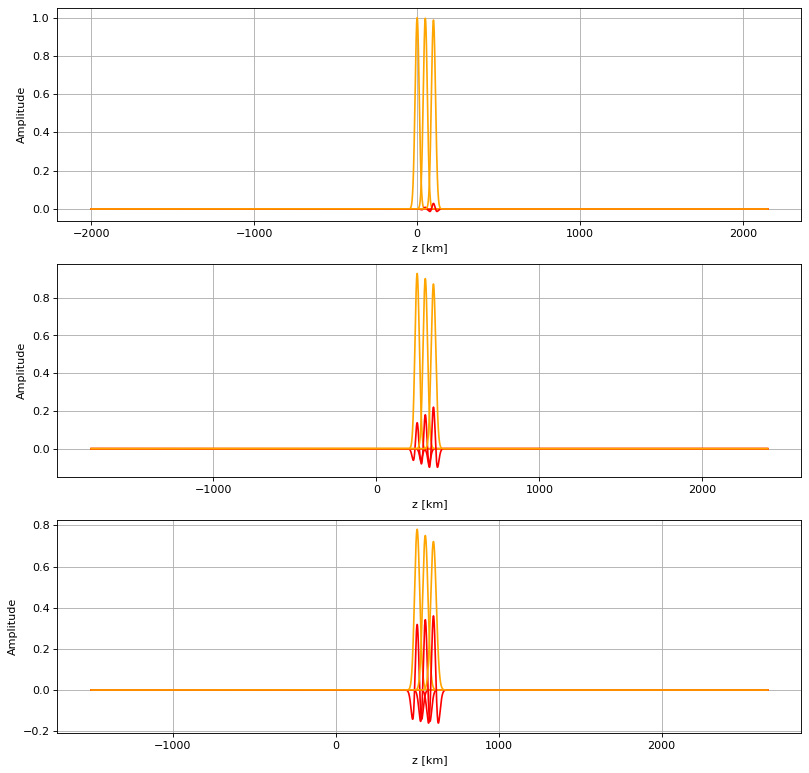

In [12]:
# now we use the parameters - example
example_h0 = h0.subs(params)
display(example_h0)
example_first = first_error.subs(D, Dsigma).subs(params)
display(example_first)
delta = lambdify((z, m), example_first , "numpy")

zm = -1 * params[T]/(params[beta2] * params[Omega])
print("Inter-collision spacing: ", zm/1e3, "km")
h = lambdify((z, m), instance, "numpy")
h_approx = lambdify((z, m), instance_approx, "numpy")


counter = 0
window_steps = 10
N_collisions = 3
decimation = 2

guard = 2000000
fig9, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), dpi=80)
for p in ax:
    start_collision = counter * window_steps

    first_zm = - start_collision * params[T] / (params[beta2] * params[Omega]) 
    last_zm = - (N_collisions * decimation + start_collision) * params[T] / (params[beta2] * params[Omega])
    space = (np.array(range(0, 10000)) * (last_zm - first_zm + 2*guard)/10000) + (first_zm - guard) # sum guards before and afters

    print("From ", space[0]/1000, "km", "to ", space[-1]/1000, "km :")
    print("\tCollisions number :", *[k*decimation + start_collision for k in range(N_collisions)], "\n")
    
    for k in [k*decimation + start_collision for k in range(N_collisions)]:
        p.plot(space/1e3, delta(space, k), color="red")
        p.plot(space/1e3, h(space, k), color="orange")
        p.set_xlabel("z [km]")
        p.set_ylabel("Amplitude")
        p.grid()
    counter+=1

Confrontiamo l'errore al primo ordine con l'errore calcolato

From  -2000.0 km to  2149.585 km :
	Collisions number : 0 2 4 

From  -1750.0 km to  2399.585 km :
	Collisions number : 10 12 14 

From  -1500.0 km to  2649.585 km :
	Collisions number : 20 22 24 



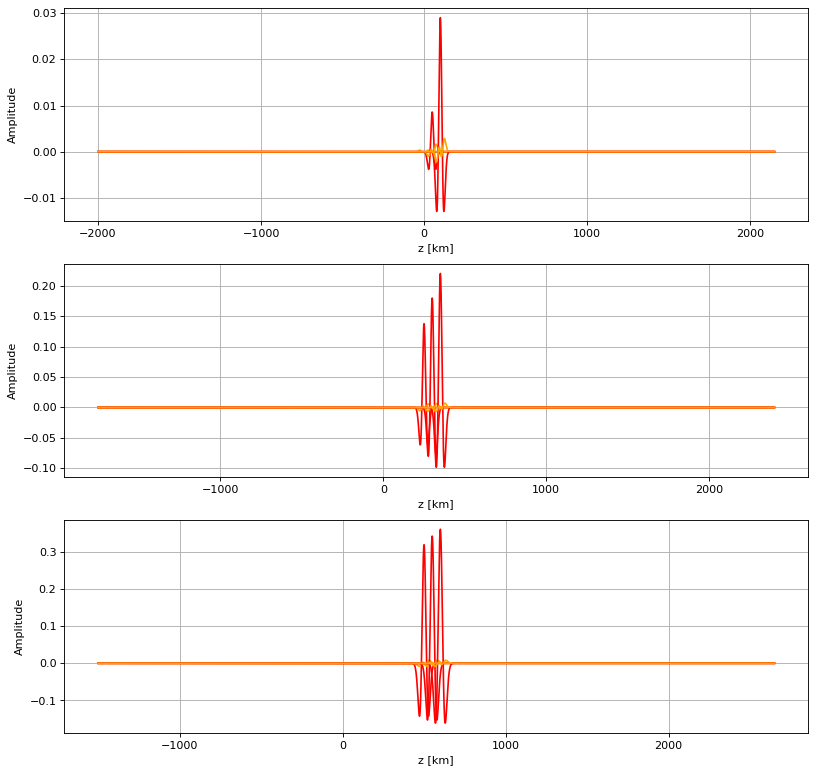

In [13]:
counter = 0
fig10, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), dpi=80)
for p in ax:
    start_collision = counter * window_steps

    first_zm = - start_collision * params[T] / (params[beta2] * params[Omega]) 
    last_zm = - (N_collisions * decimation + start_collision) * params[T] / (params[beta2] * params[Omega])
    space = (np.array(range(0, 10000)) * (last_zm - first_zm + 2*guard)/10000) + (first_zm - guard) # sum guards before and afters

    print("From ", space[0]/1000, "km", "to ", space[-1]/1000, "km :")
    print("\tCollisions number :", *[k*decimation + start_collision for k in range(N_collisions)], "\n")
    
    for k in [k*decimation + start_collision for k in range(N_collisions)]:
        p.plot(space/1e3, delta(space, k), color="red")
        p.plot(space/1e3, (h(space, k) - h_approx(space, k)), color="orange")
        p.set_xlabel("z [km]")
        p.set_ylabel("Amplitude")
        #p.set_title("From " + str(first_zm/zm) + "zm to " + str(last_zm/zm) + "zm :")
        p.grid()
    counter+=1

L'errore al primo ordine, calcolato in $\sigma$, sembra essere comunque troppo grossolano per essere usato come parametro per stimare la bontà dell'approssimazione

## Collisioni di interesse
Consideriamo solamente le collisioni che hanno, nell'intervallo [0, L], almeno `alpha` percentuale del loro integrale. Per calcolare questo ci appoggiamo all'approssimazione gaussiana, ed escludiamo il contributo di $\large f_B(z)$

In [14]:
params = {Omega:1000e9,    # 100GHz channel spacing
          beta2:-4e-27,  # standard dispersion (low side)
          T0:50e-12,    # 100ps half width 1/e power
          T:1e-10}       # 100ps: 10GHz modulation 

Omega, beta2, T0, T = params.values()
L = 100e3
upper_end = lambda n: (n*T + beta2*Omega*L)/(np.sqrt(2) * T0 * np.sqrt(1 + (- n * T / (Omega * T0))**2)) 
lower_end = lambda n: (n*T)/(np.sqrt(2) * T0 * np.sqrt(1 + (- n * T / (Omega * T0))**2))
print(upper_end(2))

-2.82842712474619


In [15]:
from scipy.optimize import root_scalar

In [16]:
def collision_quality(k, aa):
    return (erf(lower_end(k))-erf(upper_end(k)))/2 - aa

alpha = 0.1

#for j in range(100):
    #print(collision_quality(j, alpha))

solution = root_scalar(lambda k: collision_quality(k, alpha), bracket = [0, 1000])
print(type(solution))
*_,critical_m = solution

<class 'scipy.optimize.zeros.RootResults'>


TypeError: cannot unpack non-iterable RootResults object